<a href="https://colab.research.google.com/github/pkumar2143/cancer-detect-revisit/blob/main/CVforBreastCancerDetection_Revisited.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Vision Project for Breast Cancer Detection
This project is a revisit to a grad project I undertook creating a CNN-based system for detecting breast cancer in RGB images; see the repo [here](https://github.com/pkumar2143/CNN-CompVis). I initially could not improve the performance of my model at the time more than about 86% due to time and resource constraints, but let's see if we can do so now.

### The Dataset

From the Kaggle Dataset, Breast Histopathology:
The original dataset consisted of 162 whole mount slide images of Breast Cancer (BCa) specimens scanned at 40x. From that, 277,524 patches of size 50 x 50 were extracted (198,738 IDC negative and 78,786 IDC positive). Each patch’s file name is of the format: u_xX_yY_classC.png — > example 10253_idx5_x1351_y1101_class0.png . Where u is the patient ID (10253_idx5), X is the x-coordinate of where this patch was cropped from, Y is the y-coordinate of where this patch was cropped from, and C indicates the class where 0 is non-IDC and 1 is IDC.

In [26]:
import sys
import os
import kagglehub
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
# Download latest dataset version
path = kagglehub.dataset_download("paultimothymooney/breast-histopathology-images")

print("Path to dataset files:", path)

100%|██████████| 3.10G/3.10G [00:30<00:00, 110MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/paultimothymooney/breast-histopathology-images/versions/1


In [3]:
%cd /root/.cache/kagglehub/datasets/

/root/.cache/kagglehub/datasets


In [4]:
# Exploring folders
print(len(os.listdir(path)))

280


There are actually 279 folders, which by the dataset description above, represent 279 patients. The 280th dir seems to be a copy of the dataset within the dataset, need to check further...

In [5]:
# Seems to be a copy of the dataset within the dataset, need to check further...
print(len(os.listdir("/root/.cache/kagglehub/datasets/paultimothymooney/breast-histopathology-images/versions/1/IDC_regular_ps50_idx5")))

279


In [6]:
print(os.listdir(path))

['12949', '9265', '13022', '12867', '10301', '15634', '9344', '9135', '9022', '16014', '9126', '13462', '12869', '12935', '10276', '16569', '12930', '8917', '9044', '9346', '13025', '12951', '16550', '9261', '13461', '8916', '10290', '9255', '12876', '8951', '10269', '10279', '12893', '13106', '15472', '9076', '9029', '9325', '9256', '13021', '12878', '14304', '9176', '9322', '9023', '15632', '13613', '16532', '12933', '14154', '12881', '13617', '10293', '12947', '16551', '15514', '9250', '9381', '10273', '13023', '12882', '10299', '9173', '12905', '10288', '12241', '10259', '13460', '14153', '14082', '13401', '14211', '12908', '8959', '16553', '10300', '9345', '12898', '16570', '12879', '13616', '13018', '12906', '13459', '10257', '9258', '10255', '9175', '10262', '15840', '15473', '9257', '9083', '8918', '9382', '9123', '15513', '8955', '14155', '13591', '9290', '13694', '9267', '12872', '9266', '12931', '13666', '12955', '12900', '9043', '10285', '9259', '10277', '14189', '9035', '1

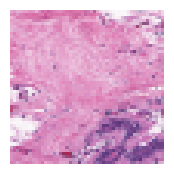

In [25]:
patients_list = os.listdir(path)
image = Image.open(path + "/10253/0/10253_idx5_x1001_y1001_class0.png")
plt.figure(figsize=(2, 2))
plt.imshow(image)
plt.axis('off') # Hide axes for cleaner display
plt.show()

Patient ID: 8864 Class: 1
Patient ID: 8918 Class: 1
Patient ID: 10269 Class: 0
Patient ID: 12898 Class: 1
Patient ID: 14082 Class: 1
Patient ID: 13691 Class: 0
Patient ID: 13400 Class: 0
Patient ID: 9225 Class: 1
Patient ID: 10256 Class: 1


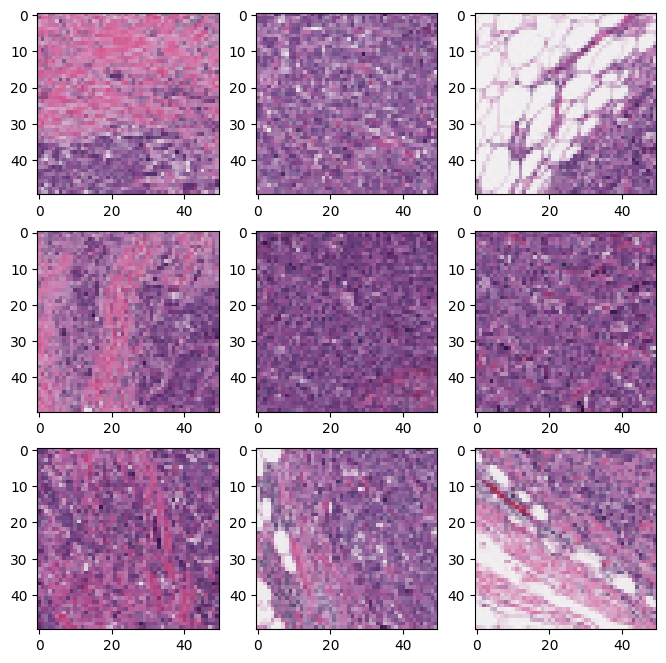

In [38]:
# Playing around with visualization
n_row = n_col = 3
fsize = n_row * 2 + 2
for i in range(n_row * n_col): # Randomly constructing the imgs array
  rand_patient = random.choice(patients_list)
  rand_patient = random.choice(patients_list)
  pos_neg_rand = str(random.randint(0,1))
  print("Patient ID:", rand_patient, "Class:", pos_neg_rand)
  imgs = [np.asarray(Image.open(path + "/"+rand_patient+"/"+pos_neg_rand+"/" + file)) for file in os.listdir(path + "/"+rand_patient+"/"+pos_neg_rand)[:n_row * n_col]]

_, axs = plt.subplots(n_row, n_col, figsize=(fsize,fsize))
axs = axs.flatten()
for img, ax in zip(imgs, axs):
    ax.imshow(img)
plt.show()